In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 3) array of binary states into (N, M) indices in [0..7].

    Mapping:
      - [a, b, c] are binary bits (0 or 1), forming a 3-bit number: a*4 + b*2 + c
      - NaN-safe: if any of the 3 elements is NaN, output is NaN

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 3).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M) with values in [0..7] or NaN.
    """
    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 3:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 3).")

    nan_mask = np.isnan(all_state_array).any(axis=-1)
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    valid_mask = ~nan_mask
    valid_data = all_state_array[valid_mask]  # shape (?, 3)

    a = valid_data[:, 0]
    b = valid_data[:, 1]
    c = valid_data[:, 2]

    result = (a * 4 + b * 2 + c).astype(float)
    indexed_states[valid_mask] = result

    return indexed_states


In [5]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## The Trans Population overtime Plot

In [6]:
omega_all_state = []
state_num = 3

for i in range(state_num):
    omega_state = np.array(Data.load(f'omega_data/omegas_state{i}.pkl').array_list)
    omega_all_state.append(omega_state)

omega_all_state = np.array(omega_all_state)
print(omega_all_state.shape)
omega_all_state

(3, 337514, 3)


array([[[-161.49103   , -179.80545   ,  -24.096935  ],
        [-166.63673   , -159.26807   ,   14.516362  ],
        [  -4.8851023 ,   12.657246  ,   25.940348  ],
        ...,
        [-163.96266   , -177.23808   , -174.64047   ],
        [ 169.03029   , -177.2965    , -158.70917   ],
        [ 163.55219   , -161.95343   ,  175.35597   ]],

       [[ -22.270863  ,   49.99021   ,   48.571697  ],
        [ -15.990163  ,   20.138498  ,   20.551126  ],
        [-155.8487    , -168.11469   ,   -4.182635  ],
        ...,
        [  36.903297  ,  -27.265247  ,  165.55731   ],
        [  28.32397   ,   -0.54085493,  178.17331   ],
        [ -25.51987   ,   -3.6644127 , -170.46968   ]],

       [[  67.603584  ,   34.682243  ,   81.15707   ],
        [ -14.069237  ,   51.71863   ,   68.75429   ],
        [ -65.57251   ,   39.629536  ,   54.828228  ],
        ...,
        [ 138.07407   ,  -97.49122   ,  -81.734856  ],
        [ 148.40062   ,  -95.236336  ,  -77.16255   ],
        [ 111.77571   

In [7]:
ntraj = len(omega_all_state)
print('np.array(omega_all_state).shape', np.array(omega_all_state).shape)

cistrans = omega2cistrans(omega_all_state)
print('cistrans.shape', cistrans.shape)

cistrans[0, :10, :]


np.array(omega_all_state).shape (3, 337514, 3)
cistrans.shape (3, 337514, 3)


array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [8]:
# Convert the cistrans into 8 state [0...7]

all_comform = state_to_index_vectorized(cistrans)
all_comform.shape

(3, 337514)

In [9]:
conform_thermo_all_population = []
state_num = 3
conform_num = 8

for thermo in range(state_num):
    traj = all_comform[thermo]
    conform_all_population = calculate_conform_p(traj, conform_num)
    
    conform_thermo_all_population.append(conform_all_population)

conform_thermo_all_population = np.array(conform_thermo_all_population)

print('trans_all_population.shape', conform_thermo_all_population.shape)

trans_all_population.shape (3, 8, 337514)


In [10]:
os.makedirs('population_data', exist_ok=True)
population_result = [conform_thermo_all_population]
data_instance = Data(population_result)
data_instance.save("population_data/population_8_conform.pkl")

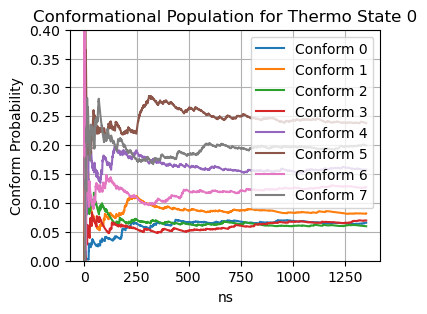

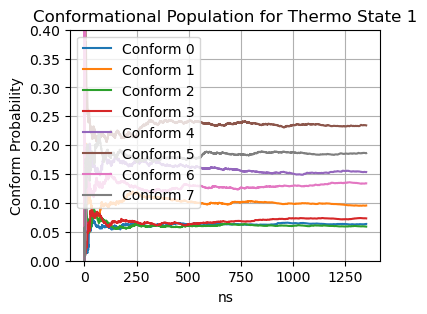

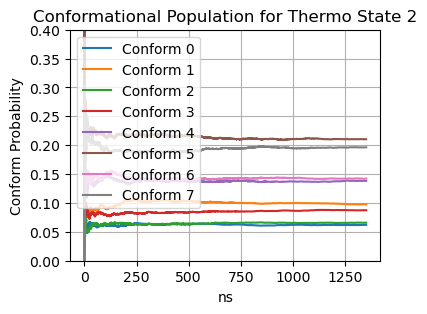

In [11]:
thermo_num = 3
conform_num = 8
dt_in_ns = 0.004 # 4ps

for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(4, 3))
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        plt.plot(x * dt_in_ns, y, label=f'Conform {conform}')

    plt.title(f'Conformational Population for Thermo State {thermo}')
    plt.xlabel('ns')
    plt.ylabel('Conform Probability')
    plt.ylim(0, 0.4)
    plt.grid(True)
    plt.legend(loc="best")
    #plt.tight_layout()
    plt.show()


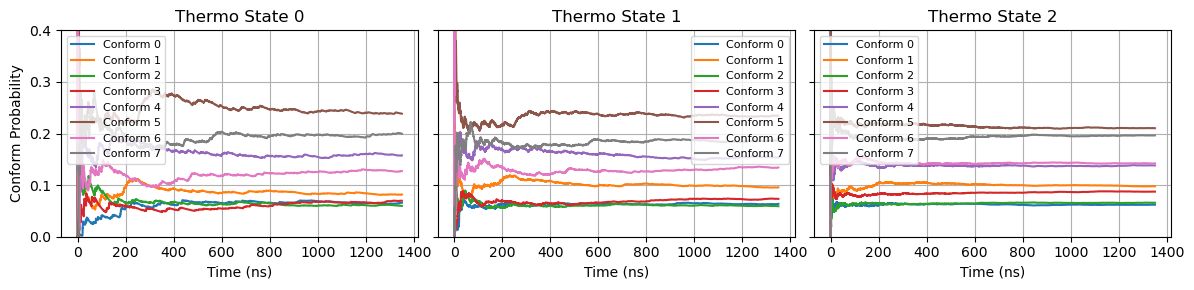

In [13]:
import matplotlib.pyplot as plt
import numpy as np

thermo_num = 3
conform_num = 8
dt_in_ns = 0.004  # 4 ps

fig, axes = plt.subplots(1, thermo_num, figsize=(12, 3), sharey=True)

x = np.arange(conform_thermo_all_population.shape[2]) * dt_in_ns  # Time axis

for thermo in range(thermo_num):
    ax = axes[thermo]

    for conform in range(conform_num):
        y = conform_thermo_all_population[thermo, conform, :]
        ax.plot(x, y, label=f'Conform {conform}')

    ax.set_title(f'Thermo State {thermo}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylim(0, 0.4)
    ax.grid(True)
    if thermo == 0:
        ax.set_ylabel('Conform Probability')
    ax.legend(fontsize=8, loc="best")

plt.tight_layout()
plt.show()


## Population Over Times against Stationary population

In [14]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime_8conforms.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='mean')
pivot_std = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='std')

# Convert to NumPy arrays
trans_refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
trans_refer_err_array.shape

(3, 8)

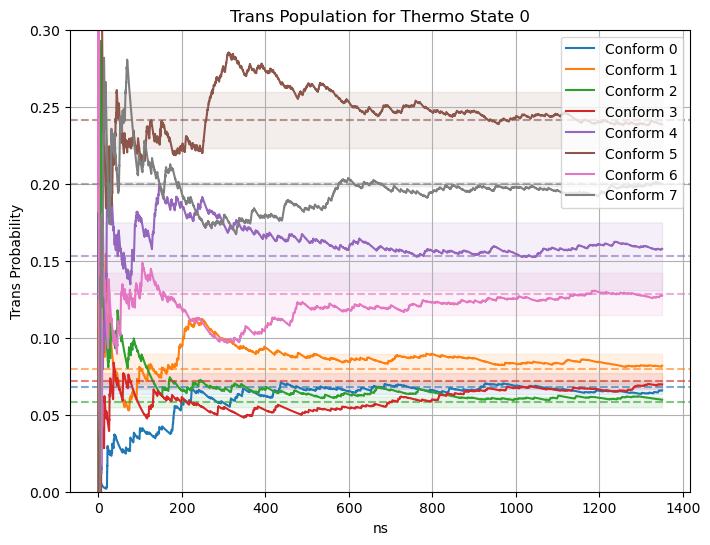

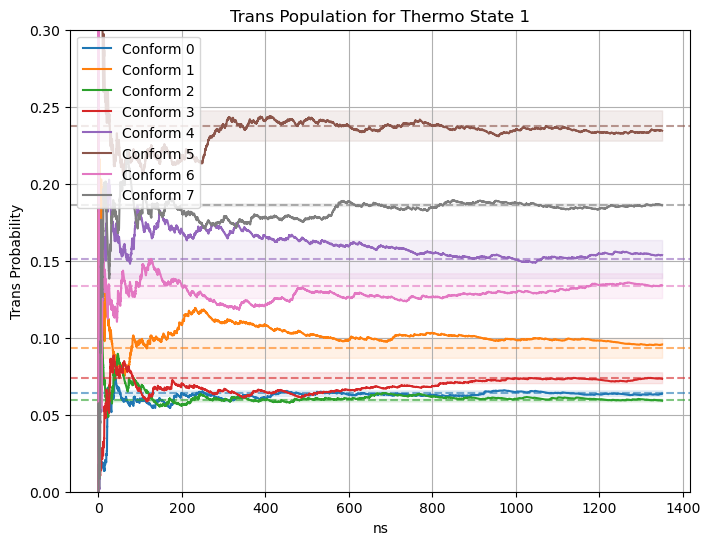

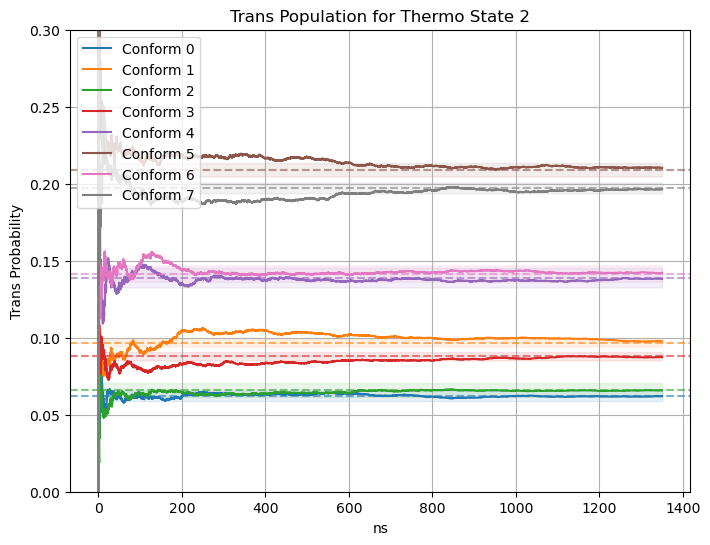

In [15]:
thermo_num = 3
conform_num = 8
dt_in_ns = 0.004 # 4ps

for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(8, 6))
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        plt.plot(x * dt_in_ns, y, label=f'Conform {conform}')

        # Reference horizontal line
        ref_y = trans_refer_array[thermo, conform]
        ref_yerr = trans_refer_err_array[thermo, conform]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{conform}', alpha=0.6)
        plt.fill_between(x * dt_in_ns, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{conform}', alpha=0.1)

    plt.title(f'Trans Population for Thermo State {thermo}')
    plt.xlabel('ns')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend(loc='best')
    #plt.tight_layout()
    plt.ylim(0, 0.3)
    plt.show()


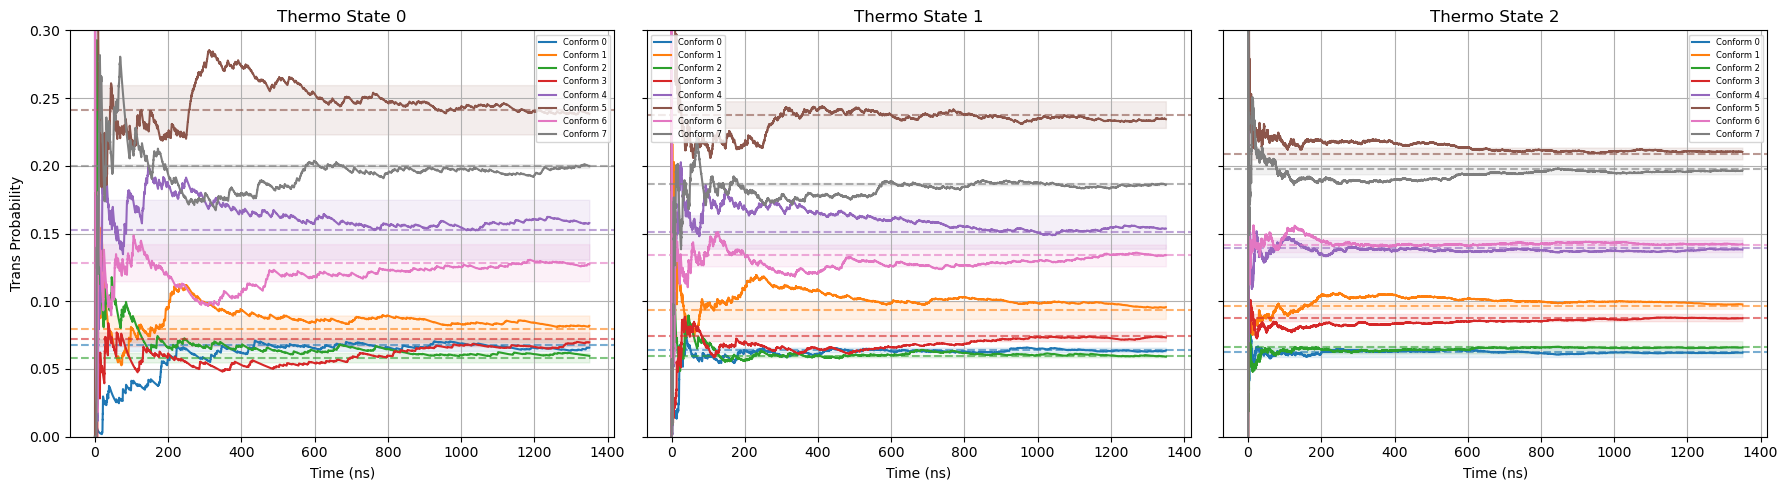

In [16]:
import matplotlib.pyplot as plt
import numpy as np

thermo_num = 3
conform_num = 8
dt_in_ns = 0.004  # 4 ps

fig, axes = plt.subplots(1, thermo_num, figsize=(18, 5), sharey=True)

x = np.arange(conform_thermo_all_population.shape[2]) * dt_in_ns  # Time axis in ns

for thermo in range(thermo_num):
    ax = axes[thermo]

    for conform in range(conform_num):
        y = conform_thermo_all_population[thermo, conform, :]
        ref_y = trans_refer_array[thermo, conform]
        ref_yerr = trans_refer_err_array[thermo, conform]

        ax.plot(x, y, label=f'Conform {conform}')
        ax.axhline(y=ref_y, linestyle='--', color=f'C{conform}', alpha=0.6)
        ax.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{conform}', alpha=0.1)

    ax.set_title(f'Thermo State {thermo}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylim(0, 0.3)
    ax.grid(True)
    if thermo == 0:
        ax.set_ylabel('Trans Probability')
    ax.legend(fontsize=6, loc='best')

plt.tight_layout()
plt.show()


### Plot the ERROR

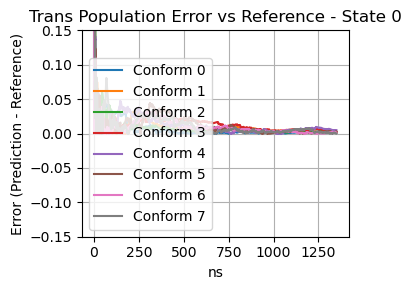

/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


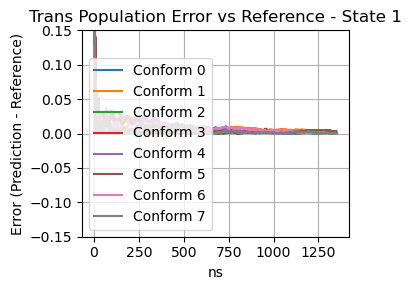

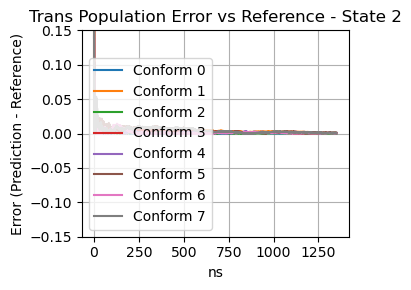

In [17]:
thermo_num = 3
conform_num = 8
dt_in_ns = 0.004 # 4ps

errors_all = []
errors_err_all = []
for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(4, 3))
    errors = []
    errors_err = []
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        # Reference horizontal line
        ref_y = trans_refer_array[thermo, conform]

        error = y - ref_y
        error = np.abs(error) # Take the absolute error 
        errors.append(error)
        plt.plot(x * dt_in_ns, error, label=f'Conform {conform}')    
    
    errors_all.append(errors)               # list of 8 arrays
    
    plt.title(f'Trans Population Error vs Reference - State {thermo}')
    plt.xlabel('ns')
    plt.ylabel('Error (Prediction - Reference)')
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.15, 0.15)
    plt.tight_layout()
    plt.show()


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_32904/1878493955.py:31: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


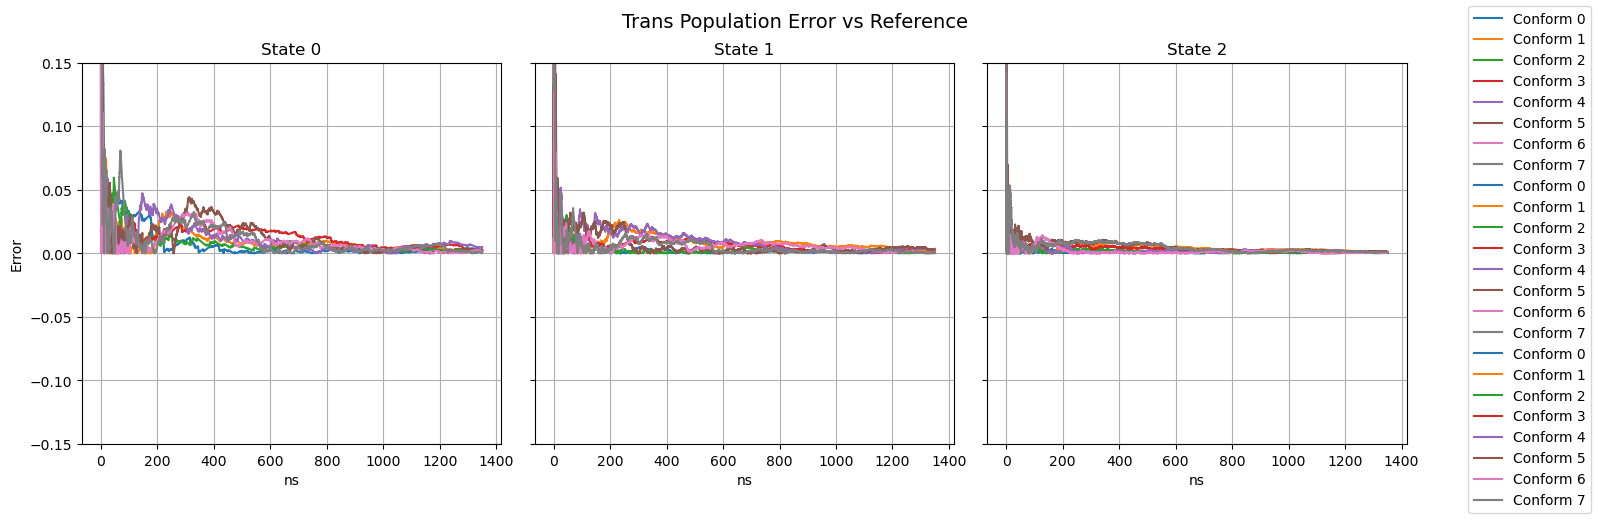

In [21]:
thermo_num = 3
conform_num = 8
dt_in_ns = 0.004  # 4 ps
errors_all = []
errors_err_all = []

fig, axs = plt.subplots(1, thermo_num, figsize=(16, 5), sharey=True)  # 1x3 grid

for thermo in range(thermo_num):  # Loop over 3 thermodynamic states
    ax = axs[thermo]
    errors = []
    errors_err = []
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values
        ref_y = trans_refer_array[thermo, conform]

        error = np.abs(y - ref_y)
        ax.plot(x * dt_in_ns, error, label=f'Conform {conform}')
        errors.append(error)
    ax.set_title(f'State {thermo}')
    ax.set_xlabel('ns')
    ax.grid(True)
    ax.set_ylim(-0.15, 0.15)
    if thermo == 0:
        ax.set_ylabel('Error')
    errors_all.append(errors)
fig.suptitle('Trans Population Error vs Reference', fontsize=14)
fig.tight_layout(rect=[0, 0, 0.9, 0.95])
fig.legend(loc='best')
plt.show()


In [22]:
errors_all = np.array(errors_all)
errors_err_all = np.array(errors_err_all)
print(errors_all.shape)
print(errors_err_all.shape)
errors_result = [errors_all, errors_err_all]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_result)
data_instance.save("population_data/error_8_conform.pkl")

(3, 8, 337514)
(0,)
